In [43]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [76]:
def wea_data(start_date, end_date):
    base_url = 'https://archive-api.open-meteo.com/v1/archive?'
    params = {
        'latitude'  : '40.7834',
        'longitude' : '-73.9663',
        'start_date': start_date,
        'end_date'  : end_date,
        'hourly'     : 'apparent_temperature,precipitation,rain,snowfall',
        'timezone' :  'auto'
    }

    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        return f'Error al realizar la solicitud:{response.status_code}'
    else:
        data_json = response.json()
        df_clima = pd.DataFrame(data_json["hourly"])
        df_clima['time'] = pd.to_datetime(df_clima['time'])
        return df_clima

def prep_data(clima_data, path_taxi, zones, start_date, end_date):
    files = os.listdir(path_taxi)
    data = pd.DataFrame()
    for file in files:
        df = pd.read_parquet(path_taxi + file)
        df.columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
        df.drop(columns=['VendorID','RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'airport_fee' ], inplace=True)
        
        #Filtramos por zona, MVP va con manhattan y en tiempo de análisis
        df = df[df['PULocationID'].isin(zones)]
        filtro = (df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] <= end_date)
        df = df[filtro]

        # Completamos los datos con un taxi representativo
        standardTaxi = 9999
        co2 = 290.63
        df['vehicle_id'] = [standardTaxi] * len(df)
        df['co2_fingerprint'] = [0] * len(df)
        df['co2_fingerprint'] = df['co2_fingerprint'].apply(lambda x: co2)

        #Concatenamos la data de taxis
        data = pd.concat([data, df], axis = 0)
    
    # Se realiza el merge entre los datos de viaje y los datos de clima en terminos del comienzo del viaje
    merged = pd.merge_asof(data.sort_values('tpep_pickup_datetime'), clima_data.sort_values('time'), right_on='time', left_on='tpep_pickup_datetime', direction='nearest')
    del data
    del df
    merged = merged.groupby(['time']).agg({
        'precipitation': 'first',
        'snowfall': 'first',
        'apparent_temperature': 'first',
        'trip_distance': 'sum' }).join( merged.groupby(['time']).size().reset_index(name='cantidad_viajes').set_index(['time']))
    
    merged['time'] = merged.index
    merged['day_of_week'] = merged['time'].dt.dayofweek  # 0=lunes, 1=martes, ..., 6=domingo
    merged['hour'] = merged['time'].dt.hour
    merged = merged.reset_index(drop=True)

    return merged

def merge_data(path_taxi, zones, start_date, end_date):
    files = os.listdir(path_taxi)
    data = pd.DataFrame()
    for file in files:
        df = pd.read_parquet(path_taxi + file)
        df.columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
        df.drop(columns=['VendorID','RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'airport_fee' ], inplace=True)
        
        #Filtramos por zona, MVP va con manhattan y en tiempo de análisis
        df = df[df['PULocationID'].isin(zones)]
        filtro = (df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] <= end_date)
        df = df[filtro]

        # Completamos los datos con un taxi representativo
        standardTaxi = 9999
        co2 = 290.63
        df['vehicle_id'] = [standardTaxi] * len(df)
        df['co2_fingerprint'] = [0] * len(df)
        df['co2_fingerprint'] = df['co2_fingerprint'].apply(lambda x: co2)

        #Concatenamos la data de taxis
        data = pd.concat([data, df], axis = 0)
    # Se realiza el merge entre los datos de viaje y los datos de clima en terminos del comienzo del viaje
    merged = pd.merge_asof(data.sort_values('tpep_pickup_datetime'), clima_data.sort_values('time'), right_on='time', left_on='tpep_pickup_datetime', direction='nearest')

    return merged

## Se genera el archivo ya procesado para evitar consumo de recursos durante el despliegue del modelo

In [87]:
zones = pd.read_csv('./data/taxi+_zone_lookup.csv')
manhattan = zones[ zones['Borough'] == 'Manhattan']
zones = manhattan['LocationID'].to_list()

start_date = '2023-02-01'
end_date = '2023-05-31'

path_taxi = './data/taxi/'
files = os.listdir(path_taxi)
data = pd.DataFrame()
for file in files:
    df = pd.read_parquet(path_taxi + file)
    df.columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
    df.drop(columns=['VendorID','RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'airport_fee' ], inplace=True)
    
    #Filtramos por zona, MVP va con manhattan y en tiempo de análisis
    df = df[df['PULocationID'].isin(zones)]
    
    #filtro = (df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] <= end_date)
    #df = df[filtro] Se hace en ejecución

    # Completamos los datos con un taxi representativo
    standardTaxi = 9999
    co2 = 290.63
    df['vehicle_id'] = [standardTaxi] * len(df)
    df['co2_fingerprint'] = [0] * len(df)
    df['co2_fingerprint'] = df['co2_fingerprint'].apply(lambda x: co2)

    #Concatenamos la data de taxis
    data = pd.concat([data, df], axis = 0)


In [88]:
data['time'] = data['tpep_pickup_datetime'].dt.round('H').dt.strftime('%Y-%m-%d %H:00:00')

In [93]:
# Se genera un grupo de datos filtrando los outlier de distancia
data['time'] = pd.to_datetime(data['time'])
data['day_of_week'] = data['time'].dt.day_of_week

# Calcular el IQR (rango intercuartílico) para identificar los outliers
Q1 = data.groupby('day_of_week')['trip_distance'].quantile(0.25)
Q3 = data.groupby('day_of_week')['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
data_filtered = data[data.apply(lambda row: (row['trip_distance'] >= lower_limit[row['day_of_week']]) &
                                        (row['trip_distance'] <= upper_limit[row['day_of_week']]), axis=1)]

In [104]:
data_gruped = data_filtered.groupby(['time']).agg({
    'trip_distance': 'sum' }).join( data_filtered.groupby(['time']).size().reset_index(name='cantidad_viajes').set_index(['time']))

data_gruped['time'] = data_gruped.index
data_gruped['time'] = pd.to_datetime(data_gruped['time'])
data_gruped['day_of_week'] = data_gruped['time'].dt.dayofweek  # 0=lunes, 1=martes, ..., 6=domingo
data_gruped['hour'] = data_gruped['time'].dt.hour
data_gruped = data_gruped.reset_index(drop=True)

In [108]:
data_gruped.to_csv('./data/taxi/data_prep.csv', index = False)

## Generación del resto de datos, se probo con y sin outliers

### A continuación se general los datos sin outlier en terminos de distancia de viajes.

In [45]:
start_date = '2023-02-01'
end_date = '2023-05-31'

zones = pd.read_csv('./data/taxi+_zone_lookup.csv')
manhattan = zones[ zones['Borough'] == 'Manhattan']
zones_man = manhattan['LocationID'].to_list()

clima_data = wea_data(start_date, end_date)
data = prep_data(clima_data, './data/taxi/', zones_man, start_date, end_date)

merged_df = merge_data('./data/taxi/', zones_man, start_date, end_date)

In [48]:
# Se genera un grupo de datos filtrando los outlier de distancia
merged_df['day_of_week'] = merged_df['tpep_pickup_datetime'].dt.day_of_week

# Calcular el IQR (rango intercuartílico) para identificar los outliers
Q1 = merged_df.groupby('day_of_week')['trip_distance'].quantile(0.25)
Q3 = merged_df.groupby('day_of_week')['trip_distance'].quantile(0.75)
IQR = Q3 - Q1


# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
data_filtered = merged_df[merged_df.apply(lambda row: (row['trip_distance'] >= lower_limit[row['day_of_week']]) &
                                        (row['trip_distance'] <= upper_limit[row['day_of_week']]), axis=1)]

sin_outlier_agrupados = data_filtered.groupby(['time']).agg({
    'precipitation': 'first',
    'snowfall': 'first',
    'apparent_temperature': 'first',
    'trip_distance': 'sum' }).join( data_filtered.groupby(['time']).size().reset_index(name='cantidad_viajes').set_index(['time']))

sin_outlier_agrupados['time'] = sin_outlier_agrupados.index
sin_outlier_agrupados['day_of_week'] = sin_outlier_agrupados['time'].dt.dayofweek  # 0=lunes, 1=martes, ..., 6=domingo
sin_outlier_agrupados['hour'] = sin_outlier_agrupados['time'].dt.hour
sin_outlier_agrupados = sin_outlier_agrupados.reset_index(drop=True)


### Distancia de viajes según el día

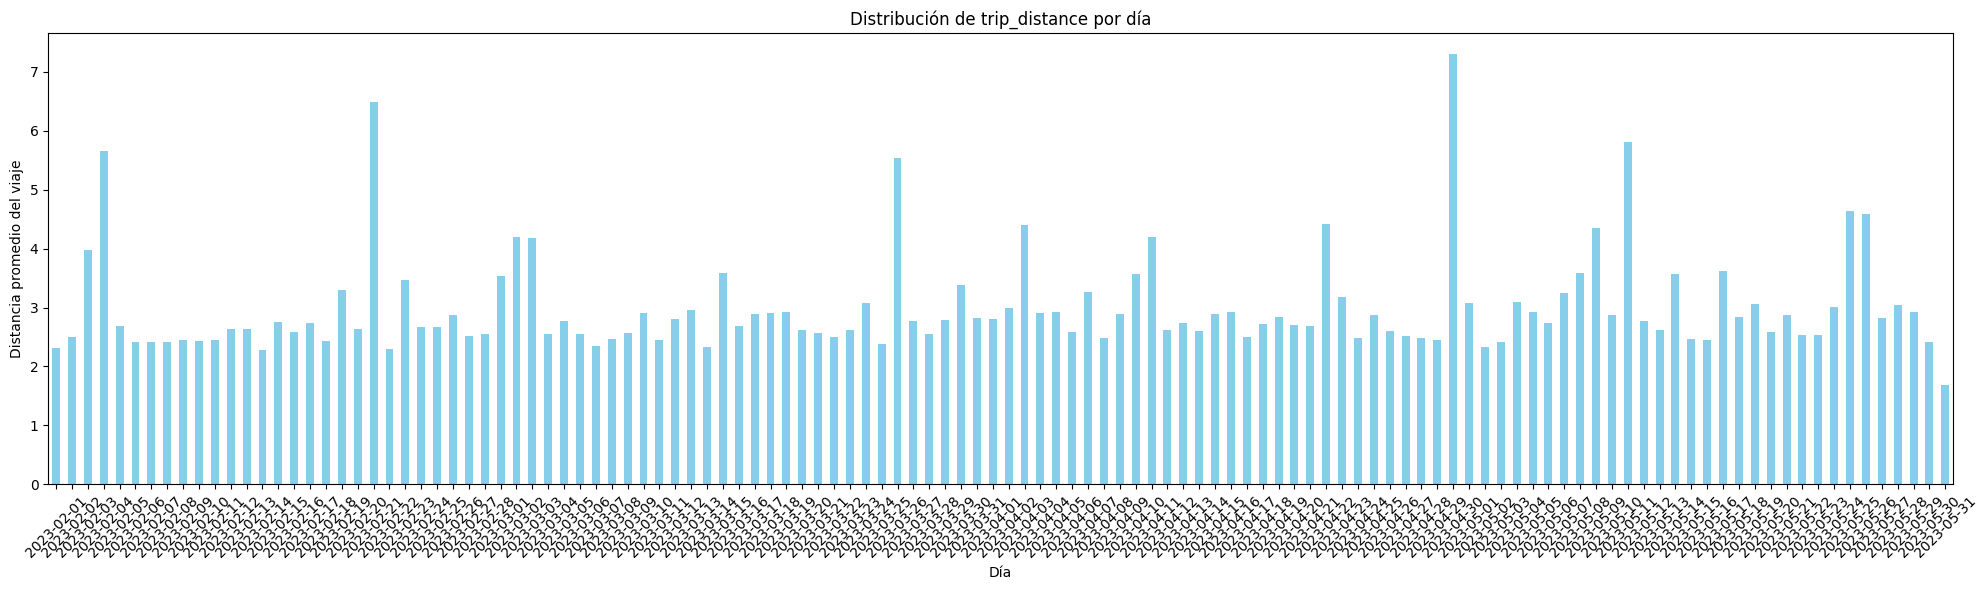

In [14]:
# Crear una nueva columna para el día
merged_df['pickup_day'] = merged_df['tpep_pickup_datetime'].dt.date

# Calcular la distribución de trip_distance por día
daily_trip_distance = merged_df.groupby('pickup_day')['trip_distance'].mean()

# Crear un gráfico de barras para la distribución de trip_distance por día
plt.figure(figsize=(20, 6))
daily_trip_distance.plot(kind='bar', color='skyblue')
plt.title('Distribución de trip_distance por día')
plt.xlabel('Día')
plt.ylabel('Distancia promedio del viaje')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### El siguiente gráfico se observa de manera más ordenada dado que se muestran los datos sin outliers.

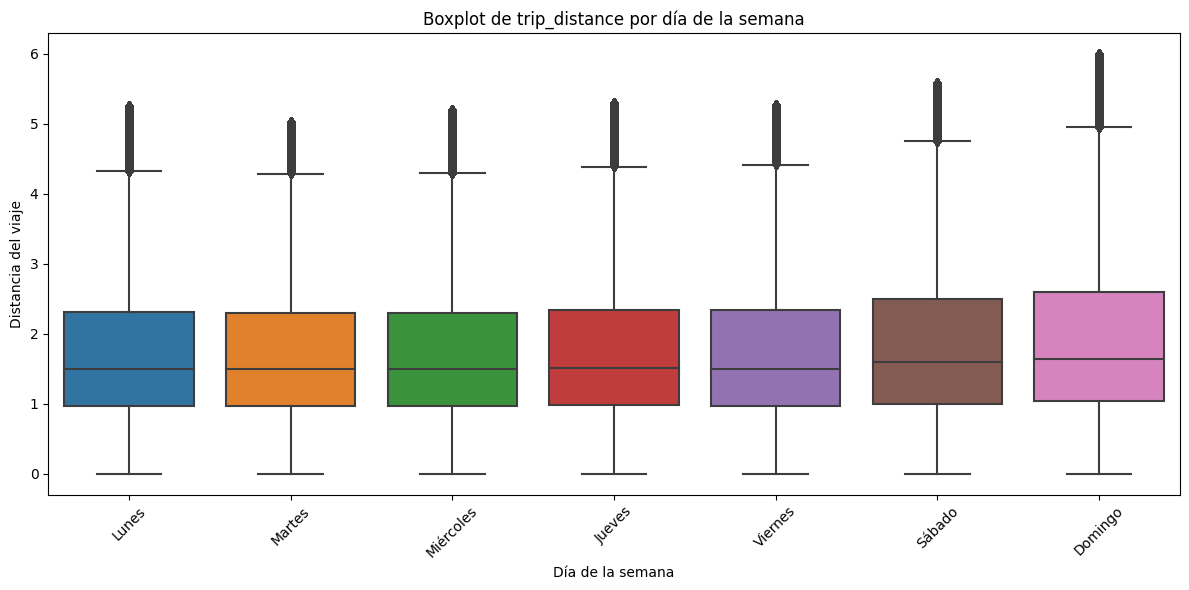

In [39]:

# Crear un boxplot de trip_distance por día de la semana
plt.figure(figsize=(12, 6))
sns.boxplot(x='pickup_day_name', y='trip_distance', data=data_filtered, order=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.title('Boxplot de trip_distance por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Distancia del viaje')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Correlación entre variables para detectar relaciones relevantes a simple vista.

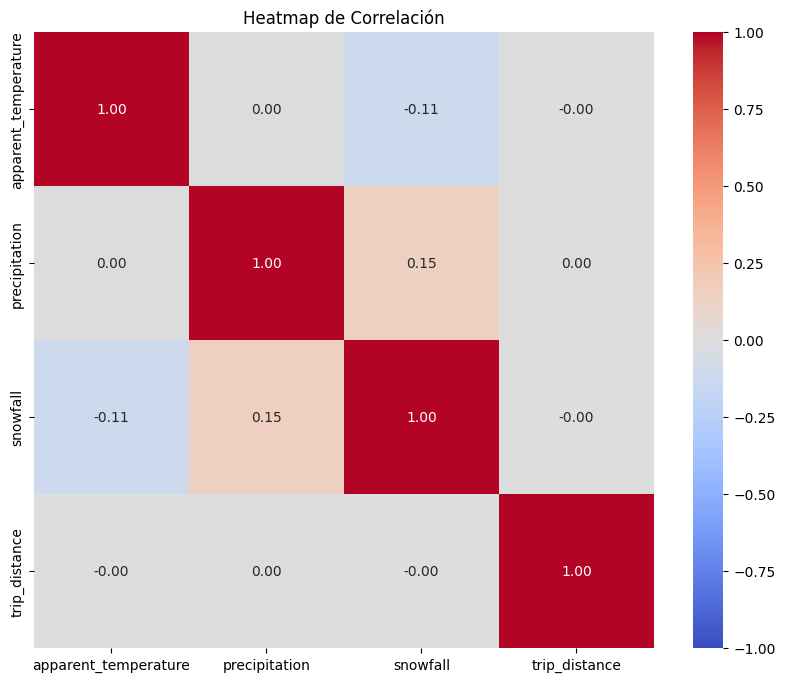

In [10]:
# Calcular la correlación
correlation_matrix = merged_df[['apparent_temperature', 'precipitation', 'snowfall', 'trip_distance']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Heatmap de Correlación')
plt.show()


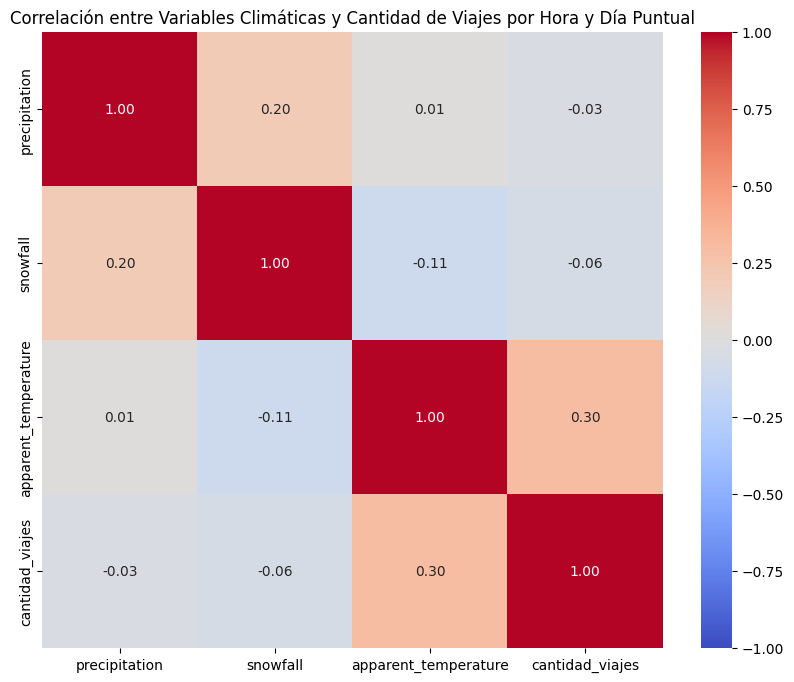

In [12]:
correlacion_climatica = data[['precipitation', 'snowfall', 'apparent_temperature', 'cantidad_viajes']].corr()

# Crear un heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_climatica, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlación entre Variables Climáticas y Cantidad de Viajes por Hora y Día Puntual')
plt.show()

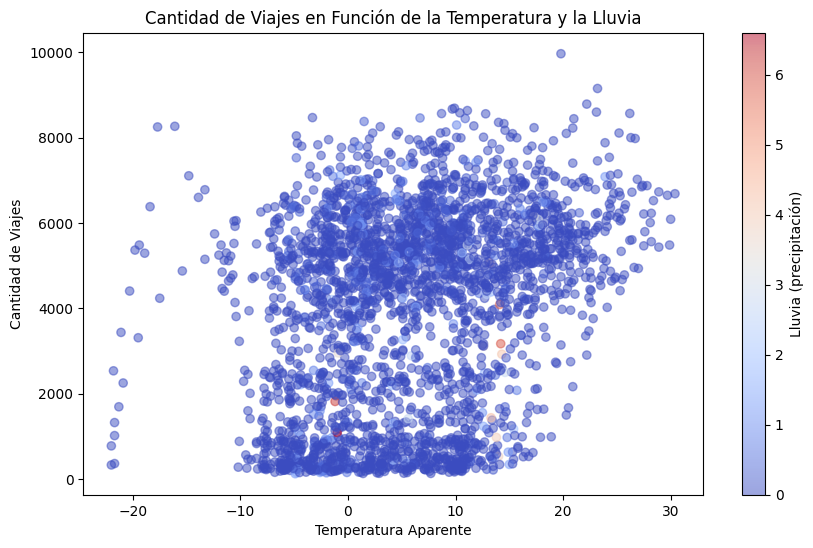

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(data['apparent_temperature'], data['cantidad_viajes'], c=data['precipitation'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Temperatura Aparente')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes en Función de la Temperatura y la Lluvia')
plt.colorbar(label='Lluvia (precipitación)')
plt.show()

C:\Users\Gaston Luna Paez\AppData\Local\Temp\ipykernel_14156\3811236096.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['apparent_temperature'], data['cantidad_viajes'], cmap='coolwarm', alpha=0.5)


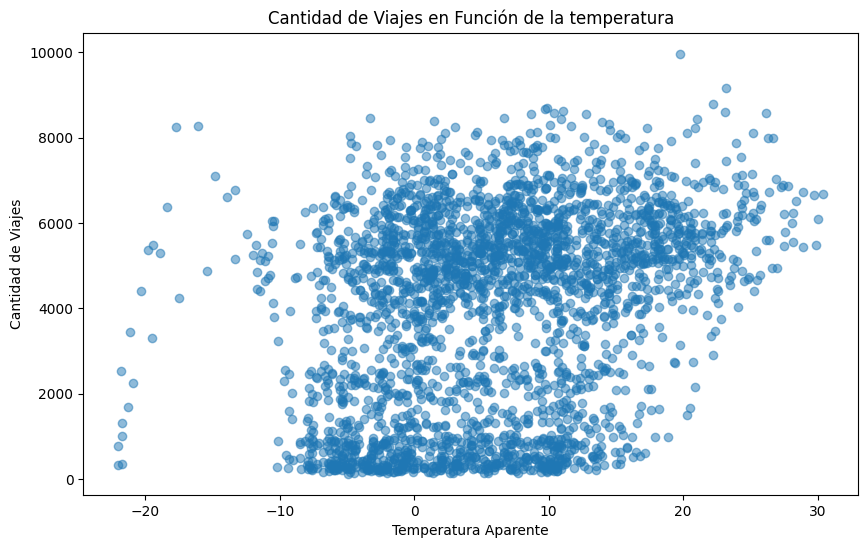

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(data['apparent_temperature'], data['cantidad_viajes'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Temperatura Aparente')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes en Función de la temperatura')
plt.show()

Aparentemente se presenta una correlación positiva entre el número de viajes y la temperatura, donde a mayor temperatura se ve gran cantidad de viajes exclusivamente, que lo que sucede a temperaturas más bajas y razonables. Es probable que sin tomamos un mes de invierno suceda inversamente lo mismo. 

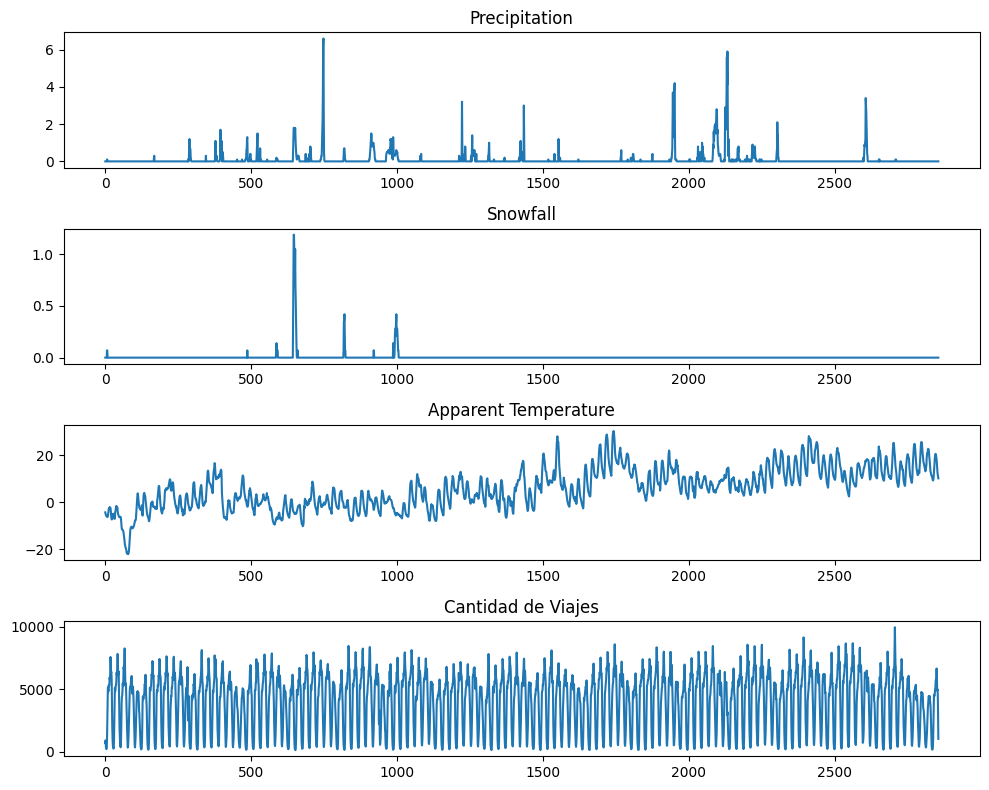

In [15]:
# Crear subplots para cada columna
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Trazar los datos en los subplots
data['precipitation'].plot(ax=axes[0], title='Precipitation')
data['snowfall'].plot(ax=axes[1], title='Snowfall')
data['apparent_temperature'].plot(ax=axes[2], title='Apparent Temperature')
data['cantidad_viajes'].plot(ax=axes[3], title='Cantidad de Viajes')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

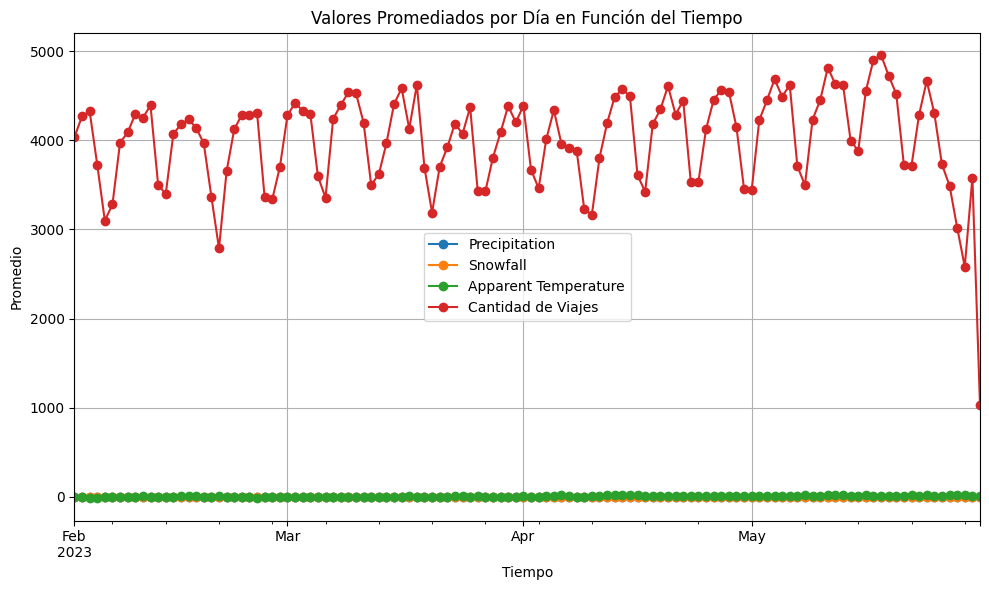

In [18]:
# Calcular los valores promediados por día

daily_means = data.set_index('time', inplace = False)
daily_means = daily_means.resample('D').mean()

# Crear un gráfico de líneas de los valores promediados por día en función del tiempo
plt.figure(figsize=(10, 6))
daily_means['precipitation'].plot(kind='line', marker='o', label='Precipitation')
daily_means['snowfall'].plot(kind='line', marker='o', label='Snowfall')
daily_means['apparent_temperature'].plot(kind='line', marker='o', label='Apparent Temperature')
daily_means['cantidad_viajes'].plot(kind='line', marker='o', label='Cantidad de Viajes')

plt.title('Valores Promediados por Día en Función del Tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Promedio')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Esos ciclos que parecen observarse aparentemente se ven asociados con los días de la semana.

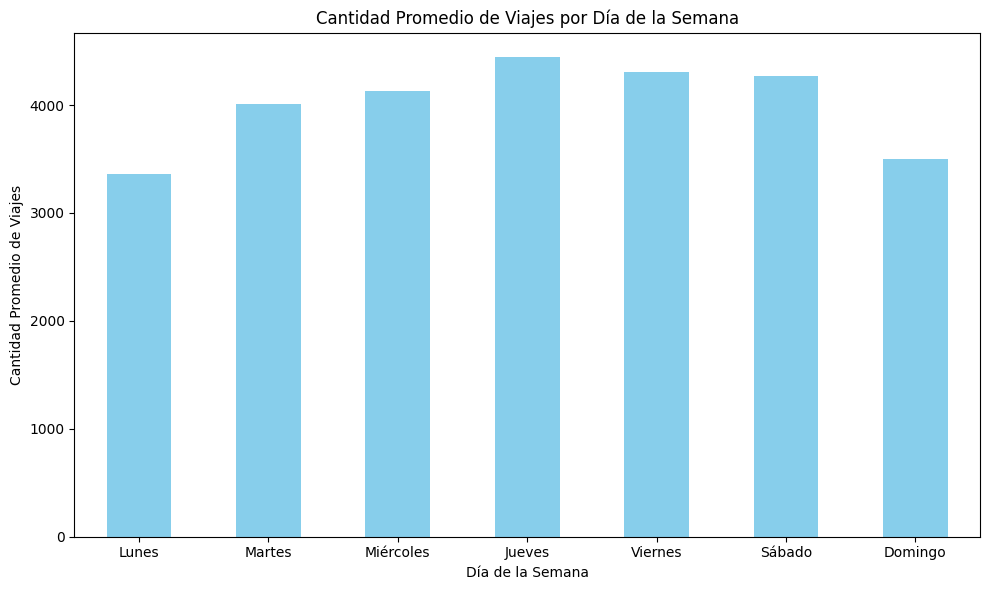

In [21]:
daily_means = data.set_index('time', inplace = False).resample('D').mean()

# Agregar una nueva columna para el día de la semana (0=lunes, 1=martes, ..., 6=domingo)
daily_means['day_of_week'] = daily_means.index.dayofweek

# Crear un gráfico de barras para mostrar el promedio de cantidad de viajes por día de la semana
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
average_trips_by_day = daily_means.groupby('day_of_week')['cantidad_viajes'].mean()

plt.figure(figsize=(10, 6))
average_trips_by_day.index = [day_names[idx] for idx in average_trips_by_day.index]
average_trips_by_day.plot(kind='bar', color='skyblue')
plt.title('Cantidad Promedio de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Promedio de Viajes')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

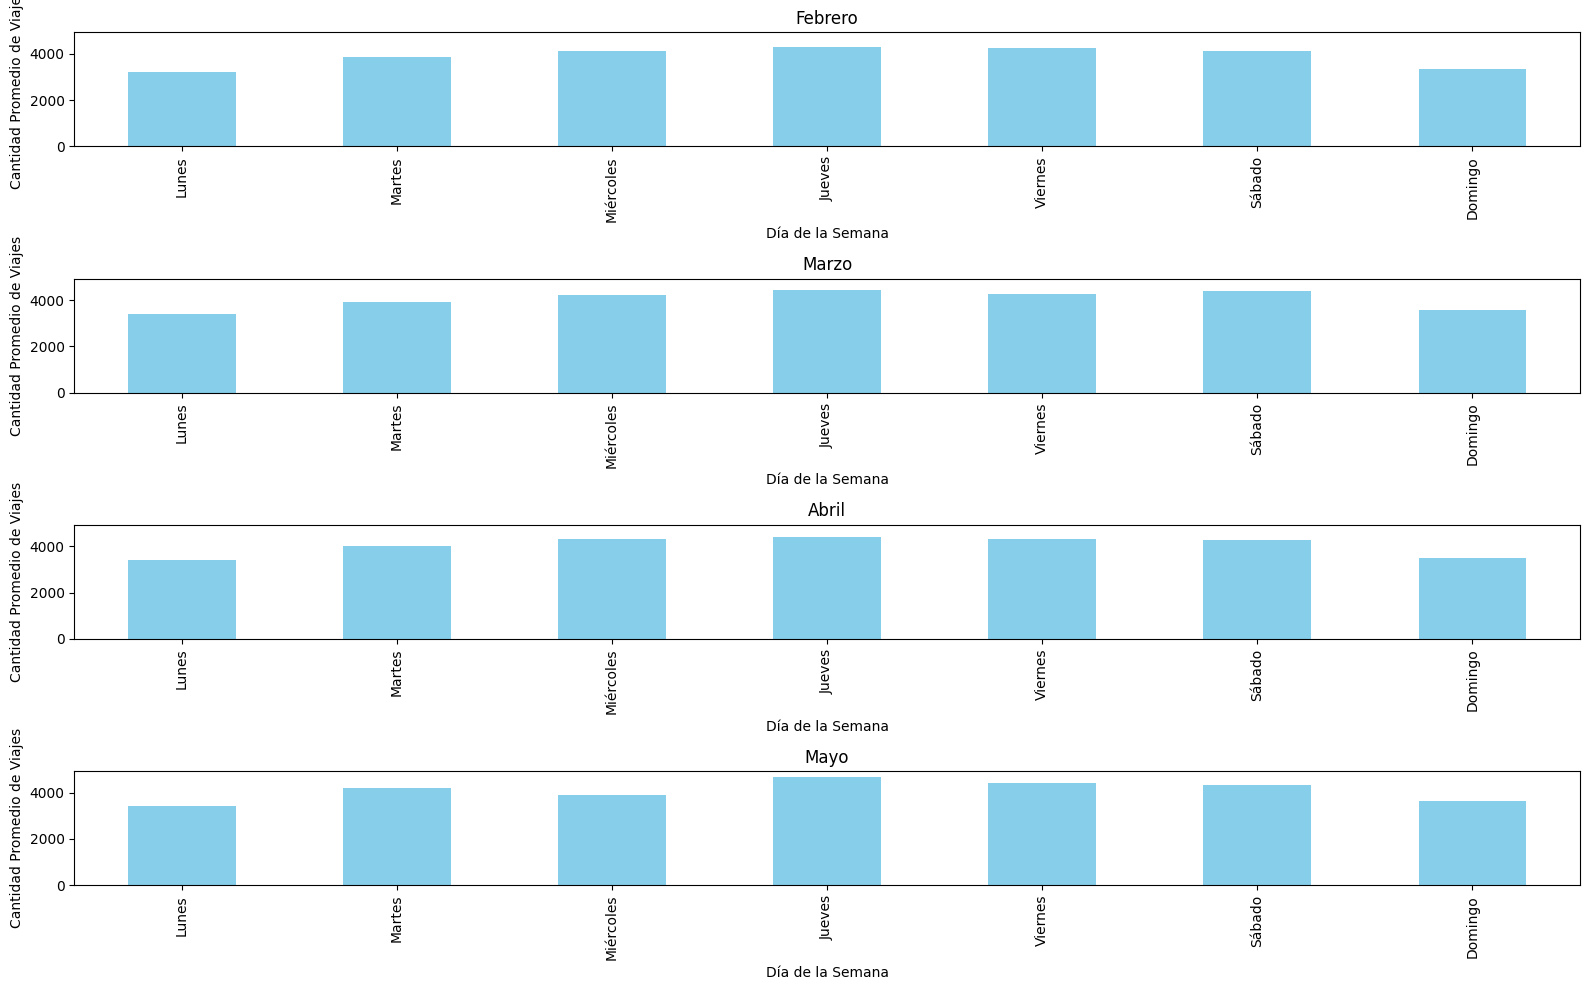

In [23]:
# Agregar una nueva columna para el mes
daily_means['month'] = daily_means.index.month

# Crear subplots para cada mes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 10), sharey=True)
fig.subplots_adjust(hspace=0.5)

# Lista de nombres de meses
month_names = ['Febrero', 'Marzo', 'Abril', 'Mayo']

for i, month in enumerate(range(2, 6)):
    ax = axes[i]
    monthly_data = daily_means[daily_means['month'] == month]
    average_trips_by_day = monthly_data.groupby('day_of_week')['cantidad_viajes'].mean()
    average_trips_by_day.index = [day_names[idx] for idx in average_trips_by_day.index]
    average_trips_by_day.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(month_names[i])
    ax.set_xlabel('Día de la Semana')
    ax.set_ylabel('Cantidad Promedio de Viajes')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Aparentemente la temperatura es un fuerte factor de influencia para los viajes, dado que en mayo se observa un aumento de los picos.

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Cargar tus datos en un DataFrame
data = viajes_por_hora_dia  # Reemplaza 'tu_archivo.csv' con el nombre de tu archivo CSV

data['time'] = data.index
data['day_of_week'] = data['time'].dt.dayofweek  # 0=lunes, 1=martes, ..., 6=domingo
data['hour'] = data['time'].dt.hour

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data[['precipitation', 'snowfall', 'apparent_temperature', 'day_of_week', 'hour']]
y = data['cantidad_viajes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Interpretar los coeficientes del modelo
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
print(coefficients)


Mean Squared Error: 2547946.4613698586
R-squared: 0.5351271812844476
                feature  coefficient
0         precipitation  -129.054157
1              snowfall  -887.773340
2  apparent_temperature    40.924947
3           day_of_week    28.404164
4                  hour   231.442989


La regresión lineal es extremeadamente simple y no da buenos resultados.

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargar tus datos y agregar las columnas de día de la semana y hora (como se hizo anteriormente)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data[['precipitation', 'snowfall', 'apparent_temperature', 'day_of_week', 'hour']]
y = data[['cantidad_viajes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo de Regresión de Bosque Aleatorio
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (Random Forest): {mse}')
print(f'R-squared (Random Forest): {r2}')


C:\Users\Gaston Luna Paez\AppData\Local\Temp\ipykernel_12172\976320697.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error (Random Forest): 257735.4708934251
R-squared (Random Forest): 0.9529761646668232


In [ ]:
data_prueba = {
    'precipitation': 20,
    'snowfall': 0.0,
    'apparent_temperature': 40.5,
    'day_of_week': 3,
    'hour': 14
}

# Convertir los datos de entrada en una matriz bidimensional
input_data = np.array([[data_prueba['precipitation'], data_prueba['snowfall'], data_prueba['apparent_temperature'], data_prueba['day_of_week'], data_prueba['hour']]])

# Realizar la predicción con el modelo
predicciones = rf_model.predict(input_data)

predicciones

c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([6076.47])

In [ ]:
fechas_de_festividad = [pd.to_datetime('2023-05-01'), pd.to_datetime('2023-02-10')]  # Fechas con festividades

# Agregar una columna "Festividad" con ceros
data['festividad'] = 0

# Establecer 1 para todas las horas del día en los días de festividad
for fecha_festiva in fechas_de_festividad:
    data.loc[data['time'].dt.date == fecha_festiva, 'festividad'] = 1

C:\Users\Gaston Luna Paez\AppData\Local\Temp\ipykernel_12172\272664371.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data.loc[data['time'].dt.date == fecha_festiva, 'festividad'] = 1


In [179]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cargar tus datos y agregar las columnas de día de la semana y hora (como se hizo anteriormente)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data[['precipitation', 'snowfall', 'apparent_temperature', 'day_of_week', 'hour']]
y = data[['cantidad_viajes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los hiperparámetros a ajustar y sus rangos
param_grid = {
    'n_estimators': [50, 100, 150],  # Diferentes números de árboles
    'max_depth': [None, 10, 20],     # Diferentes profundidades máximas
    'min_samples_split': [2, 5, 10] # Diferentes valores mínimos para dividir un nodo
}

# Crear el modelo de Regresión de Bosque Aleatorio
rf_model = RandomForestRegressor(random_state=42)

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Entrenar el modelo final con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (Random Forest): {mse}')
print(f'R-squared (Random Forest): {r2}')
print(f'Best Hyperparameters: {best_params}')


c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\G

Mean Squared Error (Random Forest): 235923.70897799334
R-squared (Random Forest): 0.9569557205156254
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}


Como una primer aproximación parece ser buena la utilización del random forest pensando en entregar un minimo producto en la entrega. En caso del cliente estar de acuerdo se escalaría.

In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cargar tus datos y agregar las columnas de día de la semana y hora (como se hizo anteriormente)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = sin_outlier_agrupados[['precipitation', 'snowfall', 'apparent_temperature', 'day_of_week', 'hour']]
y = sin_outlier_agrupados[['cantidad_viajes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los hiperparámetros a ajustar y sus rangos
param_grid = {
    'n_estimators': [50, 100, 150],  # Diferentes números de árboles
    'max_depth': [None, 10, 20],     # Diferentes profundidades máximas
    'min_samples_split': [2, 5, 10] # Diferentes valores mínimos para dividir un nodo
}

# Crear el modelo de Regresión de Bosque Aleatorio
rf_model = RandomForestRegressor(random_state=42)

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Entrenar el modelo final con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (Random Forest): {mse}')
print(f'R-squared (Random Forest): {r2}')
print(f'Best Hyperparameters: {best_params}')


c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\G

Mean Squared Error (Random Forest): 204861.85873294342
R-squared (Random Forest): 0.9580685796489624
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


Empleando los datos filtrando los outlier de distancia, que se piensan son los más influyentes, se obtiene un modelo con muchos mejores resultados. 

In [96]:
merged_data[merged_data['apparent_temperature'] > 20][0:2]

,trip_distance,cantidad_viajes,time,day_of_week,hour,apparent_temperature,precipitation,rain,snowfall
1502,14034.85,5857,2023-04-04 14:00:00,1,14,20.6,0.0,0.0,0.0
1503,15003.49,6226,2023-04-04 15:00:00,1,15,20.8,0.0,0.0,0.0


In [65]:
data_prueba = {
    'precipitation': 0,
    'snowfall': 0.0,
    'apparent_temperature': 20.4,
    'day_of_week': 1,
    'hour': 14
}

# Convertir los datos de entrada en una matriz bidimensional
input_data = np.array([[data_prueba['precipitation'], data_prueba['snowfall'], data_prueba['apparent_temperature'], data_prueba['day_of_week'], data_prueba['hour']]])
input_data = scaler.transform(input_data)
# Realizar la predicción con el modelo
predicciones = best_rf_model.predict(input_data)

predicciones

c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([5159.47771569])

## Optimización de flota

In [32]:
import pandas as pd
import numpy as np

In [33]:
df_car = pd.read_csv('./data/autos_aprobados.csv')

In [57]:
import pandas as pd
import pulp

def optimizar_flota(n_autos, autos, inversion):
    # Separar autos eléctricos y de gasolina
    autos_electricos = autos[autos['fuelType1'] == 'Electricity']
    autos_gasolina = autos[autos['fuelType1'] == 'Regular Gasoline']
    
    # Crear un problema de programación lineal
    problema = pulp.LpProblem("Optimizacion de Flota", pulp.LpMinimize)
    
    # Variables de decisión: Cantidad de cada auto a comprar
    cantidad_autos_electricos = pulp.LpVariable.dicts("CantidadAutosElectricos", autos_electricos.index, lowBound=0, cat='Integer')
    cantidad_autos_gasolina = pulp.LpVariable.dicts("CantidadAutosGasolina", autos_gasolina.index, lowBound=0, cat='Integer')
    
    # Función objetivo: Minimizar el ruido y las emisiones
    problema += pulp.lpSum([autos_electricos.loc[i, 'Noise'] * cantidad_autos_electricos[i] for i in autos_electricos.index]) + \
                pulp.lpSum([autos_gasolina.loc[i, 'Noise'] * cantidad_autos_gasolina[i] for i in autos_gasolina.index]) + \
                pulp.lpSum([autos_electricos.loc[i, 'co2'] * cantidad_autos_electricos[i] for i in autos_electricos.index]) + \
                pulp.lpSum([autos_gasolina.loc[i, 'co2'] * cantidad_autos_gasolina[i] for i in autos_gasolina.index])
    
    # Restricción: No superar el monto de inversión
    problema += pulp.lpSum([autos_electricos.loc[i, 'Price'] * cantidad_autos_electricos[i] for i in autos_electricos.index]) + \
                pulp.lpSum([autos_gasolina.loc[i, 'Price'] * cantidad_autos_gasolina[i] for i in autos_gasolina.index]) <= inversion
    
    # Restricción: Obtener al menos el 60% de autos eléctricos si es posible
    min_autos_electricos = int(0.6 * n_autos)
    problema += pulp.lpSum([cantidad_autos_electricos[i] for i in autos_electricos.index]) >= min_autos_electricos
    
    #problema += pulp.lpSum([autos.loc[i, 'fuelType1'] == 'Electricity' for i in autos.index] * [cantidad_autos[i] for i in autos.index])
    # >= min_autos_electricos

    # Restricción: Obtener exactamente n_autos en total
    problema += pulp.lpSum([cantidad_autos_electricos[i] for i in autos_electricos.index]) + \
                pulp.lpSum([cantidad_autos_gasolina[i] for i in autos_gasolina.index]) == n_autos
    
    # Resolver el problema de optimización
    problema.solve()
    
    if pulp.LpStatus[problema.status] == 'Optimal':
        # Construir la lista de autos seleccionados y sus cantidades
        autos_seleccionados_electricos = [(i, int(cantidad_autos_electricos[i].value())) for i in autos_electricos.index if cantidad_autos_electricos[i].value() > 0]
        autos_seleccionados_gasolina = [(i, int(cantidad_autos_gasolina[i].value())) for i in autos_gasolina.index if cantidad_autos_gasolina[i].value() > 0]
        
        return autos_seleccionados_electricos + autos_seleccionados_gasolina
    else:
        return [(0,0)]
def decodificar_flota(autos_seleccionados, autos):
    # Crear una lista para almacenar temporalmente las filas seleccionadas
    autos_seleccionados_lista = []
    
    # Iterar sobre las tuplas de autos seleccionados
    for auto_idx, cantidad in autos_seleccionados:
        # Obtener el auto del DataFrame original por su índice
        auto = autos.loc[auto_idx]
        
        # Repetir el auto la cantidad especificada y agregarlo a la lista
        for i in range(cantidad):
            autos_seleccionados_lista.append(auto)
    
    # Crear un DataFrame a partir de la lista de filas seleccionadas
    autos_seleccionados_df = pd.DataFrame(autos_seleccionados_lista)
    
    return autos_seleccionados_df

def buscar_inversion(inversion_inicial, n_autos_fijos):
    incremento = 10000
    autosFlota = pd.DataFrame()
    while True:
        autos_seleccionados = optimizar_flota(n_autos_fijos, df_car, inversion_inicial)
        cantidad_autos_seleccionados = sum([cantidad[1] for cantidad in autos_seleccionados])
        
        if cantidad_autos_seleccionados == n_autos_fijos:
            autosFlota = decodificar_flota(autos_seleccionados, df_car)
            return autosFlota, inversion_inicial
            break  # Hemos alcanzado la cantidad fija de autos
        else:
            inversion_inicial += incremento  # Aumentar el presupuesto en caso contrario

In [132]:

# Ejemplo de uso:
# Supongamos que tienes un DataFrame llamado 'data' que contiene tus datos
n_autos = 8
inversion = 300000

autos_seleccionados, inversion = buscar_inversion(inversion, n_autos)
autos_seleccionados

c:\Users\Gaston Luna Paez\AppData\Local\Programs\Python\Python39\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Year,Manufacturer,Model,city08,co2,co2TailpipeGpm,fuelCost08,fuelCostA08,fuelType1,ghgScore,highway08,Manufacturer_Id,range,rangeCity,rangeHwy,Noise,Price,fuelCostPerKm,fuelCost1000Km,modelComplete
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
13,2023,Kia,Niro Electric,126,0,0,600,0,Electricity,10,101,46008,253,0,0,46.0,39990,2.371542,2371.541502,KiaNiro Electric
12,2023,Kia,Niro,53,42,42,1100,0,Regular Gasoline,8,45,45673,385,0,0,46.0,23990,2.857143,2857.142857,KiaNiro
12,2023,Kia,Niro,53,42,42,1100,0,Regular Gasoline,8,45,45673,385,0,0,46.0,23990,2.857143,2857.142857,KiaNiro


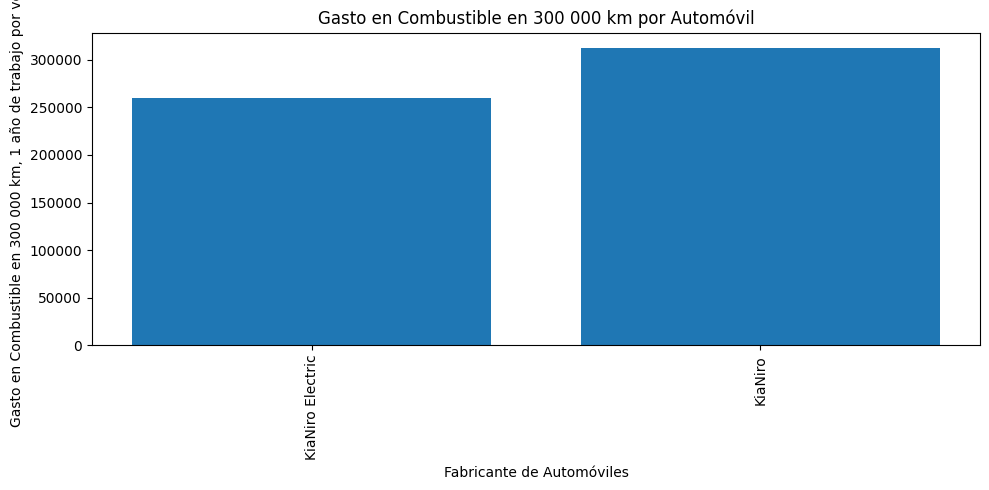

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde tu archivo o fuente de datos
# Supongamos que tienes un archivo CSV llamado 'datos_autos.csv'
data = flota

# Calcular el gasto en combustible en 1000 km para cada auto
# La columna 'fuelCost08' representa el costo de combustible por milla
# Entonces, primero convertimos el costo a costo por kilómetro
data['fuelCostPerKm'] = data['fuelCost08'] / data['range']  # 1 milla = 1.60934 km

# Luego, calculamos el gasto en combustible en 1000 km
data['fuelCost1000Km'] = data['fuelCostPerKm'] * 300 * 365

# Ahora, estamos listos para graficar
# Vamos a usar un gráfico de barras para representar el gasto en combustible
# Puedes cambiar el tipo de gráfico según tus preferencias
data['modelComplete'] = data['Manufacturer'] + data['Model']
plt.figure(figsize=(10, 5))
plt.bar(data['modelComplete'], data['fuelCost1000Km'])
plt.xlabel('Fabricante de Automóviles')
plt.ylabel('Gasto en Combustible en 300 000 km, 1 año de trabajo por vehiculo')
plt.title('Gasto en Combustible en 300 000 km por Automóvil')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [83]:
flota_gasolina = flota[flota['fuelType1'] == 'Regular Gasoline']
flota_gasolina = pd.concat([flota_gasolina] * 5, ignore_index=True)